In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

## Threshold analysis

Df before dropping [] values: 
(540, 10)
Df after dropping [] values: 
(540, 10)


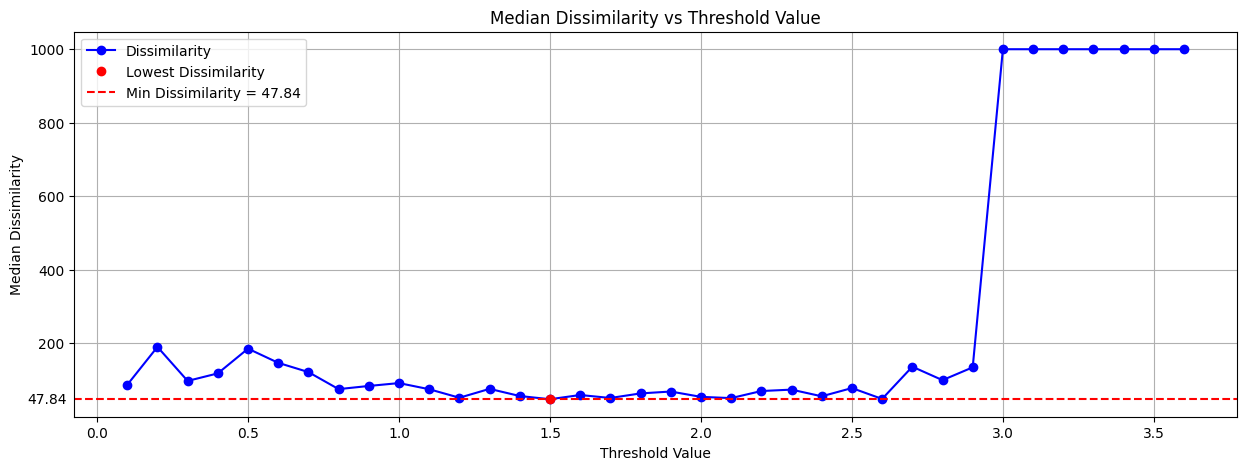

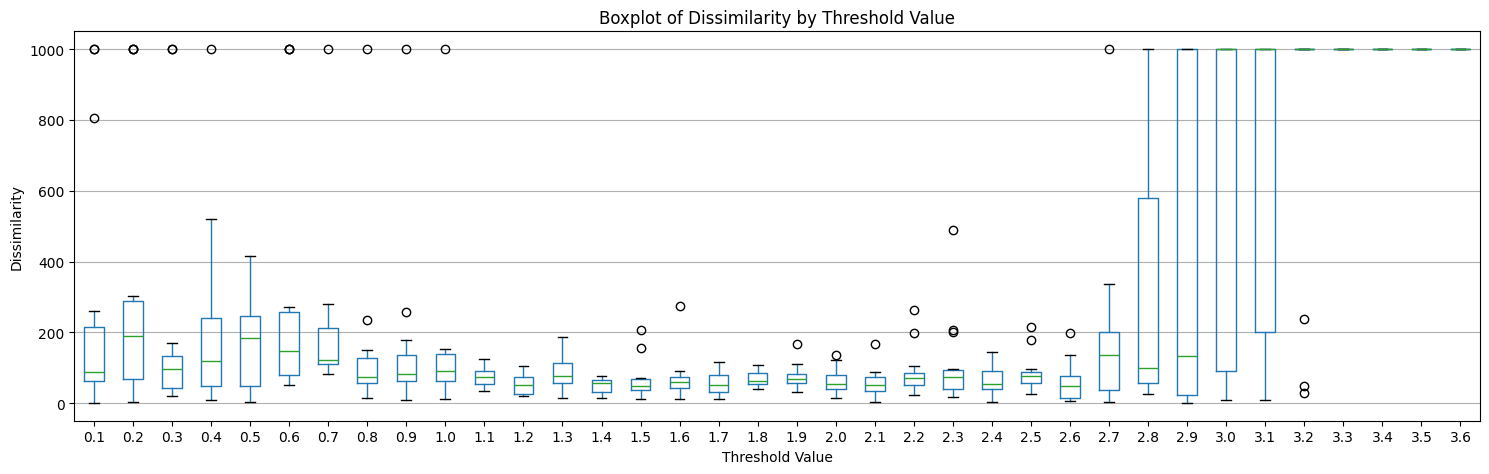

In [32]:
df = pd.read_csv('./results/df_model_test_threshold_ranges.csv')

print(f"Df before dropping [] values: \n{df.shape}")

#drop rows for which "generated_midi_data" is []
df = df[df['generated_midi_data'].apply(lambda x: x != '[]')]
df['threshold'] = df['threshold'].round(1)  # Round to 1 decimal place

print(f"Df after dropping [] values: \n{df.shape}")

# Group by the column and calculate the median of 'dissimilarity'
median_dissimilarity = df.groupby("threshold")["dissimilarity"].median()

# Find the threshold and value with the lowest dissimilarity
min_dissimilarity_value = median_dissimilarity.min()
min_threshold_value = median_dissimilarity.idxmin()

# Plotting the line plot
plt.figure(figsize=(15, 5))
plt.plot(median_dissimilarity.index, median_dissimilarity.values, marker='o', linestyle='-', color='b', label="Dissimilarity")

# Highlight the minimum point
plt.plot(min_threshold_value, min_dissimilarity_value, 'ro', label="Lowest Dissimilarity")

# Draw a red dotted line at the minimum point
plt.axhline(y=min_dissimilarity_value, color='r', linestyle='--', label=f'Min Dissimilarity = {min_dissimilarity_value:.2f}')

# Annotate the value of the lowest dissimilarity on the plot
plt.text(median_dissimilarity.index.min() - 0.2, min_dissimilarity_value, f'{min_dissimilarity_value:.2f}', 
         color='black', ha='right', va='center')
# Labeling
plt.xlabel(f'{"threshold".capitalize()} Value')
plt.ylabel('Median Dissimilarity')
plt.title(f'Median Dissimilarity vs {"threshold".capitalize()} Value')

# Display the grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Create the boxplot
ax = df.boxplot(column="dissimilarity", by="threshold", grid=False, showfliers=True)
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Set to 1 decimal place

# Adjust the figure size after creating the plot
fig = plt.gcf()
fig.set_size_inches(15, 5)

# Adjust the plot labels and title
plt.xlabel('Threshold Value')
plt.ylabel('Dissimilarity')
plt.title('Boxplot of Dissimilarity by Threshold Value')
plt.suptitle('')  # Removes the automatic title from pandas boxplot
plt.grid(True, axis='y')

# Adjust layout to prevent clipping
plt.tight_layout()

plt.show()

## Fan_out analysis

Df before dropping [] values: 
(800, 10)
Df after dropping [] values: 
(800, 10)


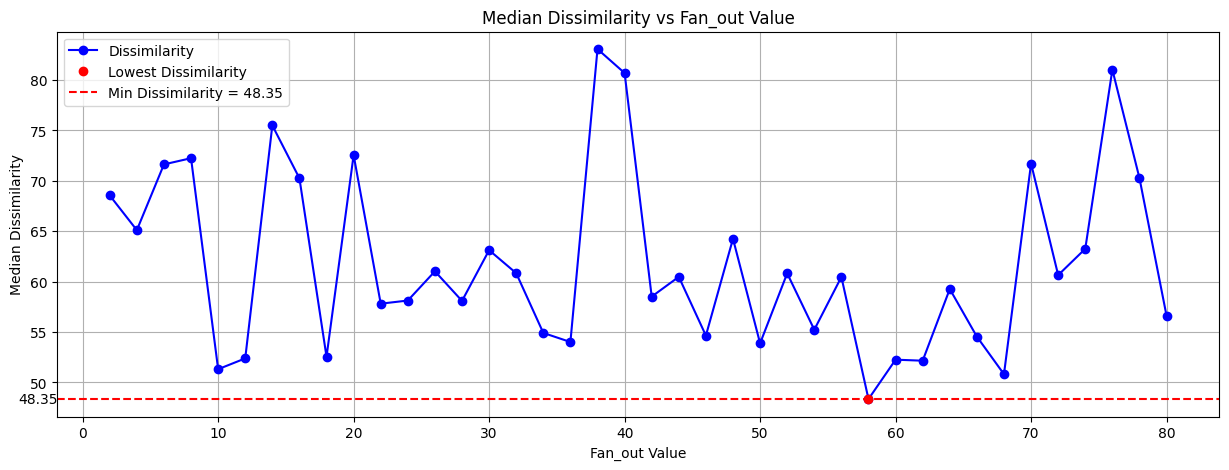

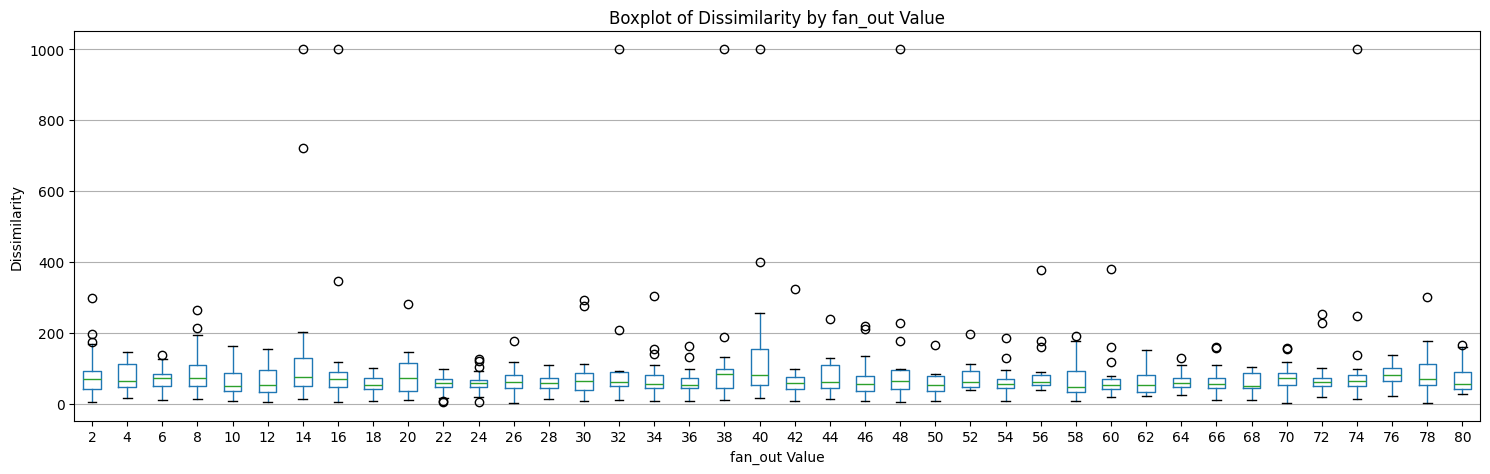

In [40]:
df = pd.read_csv('./results/df_model_test_fan_out_ranges.csv')

print(f"Df before dropping [] values: \n{df.shape}")

#drop rows for which "generated_midi_data" is []
df = df[df['generated_midi_data'].apply(lambda x: x != '[]')]
df['fan_out'] = df['fan_out'].round(1)  # Round to 1 decimal place

print(f"Df after dropping [] values: \n{df.shape}")

# Group by the column and calculate the median of 'dissimilarity'
median_dissimilarity = df.groupby("fan_out")["dissimilarity"].median()

# Find the threshold and value with the lowest dissimilarity
min_dissimilarity_value = median_dissimilarity.min()
min_threshold_value = median_dissimilarity.idxmin()

# Plotting the line plot
plt.figure(figsize=(15, 5))
plt.plot(median_dissimilarity.index, median_dissimilarity.values, marker='o', linestyle='-', color='b', label="Dissimilarity")

# Highlight the minimum point
plt.plot(min_threshold_value, min_dissimilarity_value, 'ro', label="Lowest Dissimilarity")

# Draw a red dotted line at the minimum point
plt.axhline(y=min_dissimilarity_value, color='r', linestyle='--', label=f'Min Dissimilarity = {min_dissimilarity_value:.2f}')

# Annotate the value of the lowest dissimilarity on the plot
plt.text(median_dissimilarity.index.min() - 3.8, min_dissimilarity_value, f'{min_dissimilarity_value:.2f}', 
         color='black', ha='right', va='center')
# Labeling
plt.xlabel(f'{"fan_out".capitalize()} Value')
plt.ylabel('Median Dissimilarity')
plt.title(f'Median Dissimilarity vs {"fan_out".capitalize()} Value')

# Display the grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Create the boxplot
ax = df.boxplot(column="dissimilarity", by="fan_out", grid=False, showfliers=True)
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Set to 1 decimal place

# Adjust the figure size after creating the plot
fig = plt.gcf()
fig.set_size_inches(15, 5)

# Adjust the plot labels and title
plt.xlabel('fan_out Value')
plt.ylabel('Dissimilarity')
plt.title('Boxplot of Dissimilarity by fan_out Value')
plt.suptitle('')  # Removes the automatic title from pandas boxplot
plt.grid(True, axis='y')

# Adjust layout to prevent clipping
plt.tight_layout()

plt.show()

## Max atan distance analysis

Df before dropping [] values: 
(400, 10)
Df after dropping [] values: 
(400, 10)


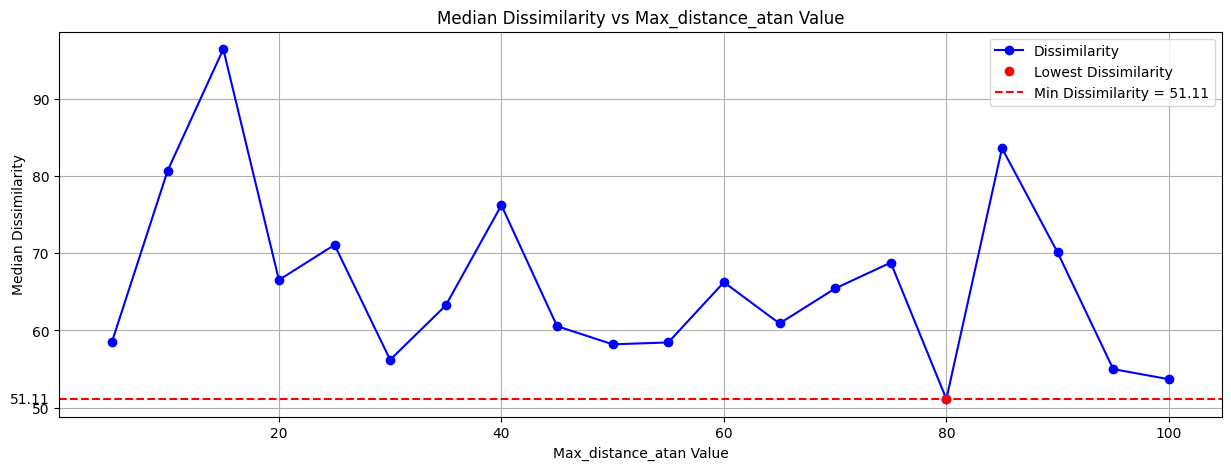

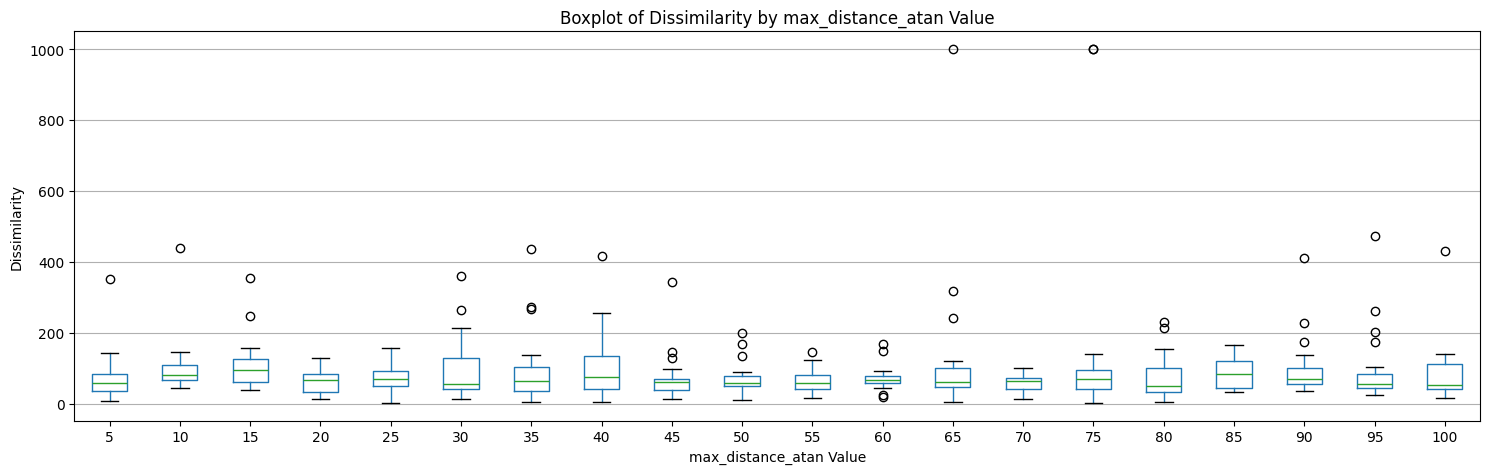

In [52]:
df = pd.read_csv('./results/df_model_test_max_distance_atan_ranges.csv')

print(f"Df before dropping [] values: \n{df.shape}")

#drop rows for which "generated_midi_data" is []
df = df[df['generated_midi_data'].apply(lambda x: x != '[]')]
df['max_distance_atan'] = df['max_distance_atan'].round(1)  # Round to 1 decimal place

print(f"Df after dropping [] values: \n{df.shape}")

# Group by the column and calculate the median of 'dissimilarity'
median_dissimilarity = df.groupby("max_distance_atan")["dissimilarity"].median()

# Find the threshold and value with the lowest dissimilarity
min_dissimilarity_value = median_dissimilarity.min()
min_threshold_value = median_dissimilarity.idxmin()

# Plotting the line plot
plt.figure(figsize=(15, 5))
plt.plot(median_dissimilarity.index, median_dissimilarity.values, marker='o', linestyle='-', color='b', label="Dissimilarity")

# Highlight the minimum point
plt.plot(min_threshold_value, min_dissimilarity_value, 'ro', label="Lowest Dissimilarity")

# Draw a red dotted line at the minimum point
plt.axhline(y=min_dissimilarity_value, color='r', linestyle='--', label=f'Min Dissimilarity = {min_dissimilarity_value:.2f}')

# Annotate the value of the lowest dissimilarity on the plot
plt.text(median_dissimilarity.index.min() - 5.6, min_dissimilarity_value, f'{min_dissimilarity_value:.2f}', 
         color='black', ha='right', va='center')
# Labeling
plt.xlabel(f'{"max_distance_atan".capitalize()} Value')
plt.ylabel('Median Dissimilarity')
plt.title(f'Median Dissimilarity vs {"max_distance_atan".capitalize()} Value')

# Display the grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Create the boxplot
ax = df.boxplot(column="dissimilarity", by="max_distance_atan", grid=False, showfliers=True)
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Set to 1 decimal place

# Adjust the figure size after creating the plot
fig = plt.gcf()
fig.set_size_inches(15, 5)

# Adjust the plot labels and title
plt.xlabel('max_distance_atan Value')
plt.ylabel('Dissimilarity')
plt.title('Boxplot of Dissimilarity by max_distance_atan Value')
plt.suptitle('')  # Removes the automatic title from pandas boxplot
plt.grid(True, axis='y')

# Adjust layout to prevent clipping
plt.tight_layout()

plt.show()

## Max key distance analysis

Df before dropping [] values: 
(300, 10)
Df after dropping [] values: 
(300, 10)


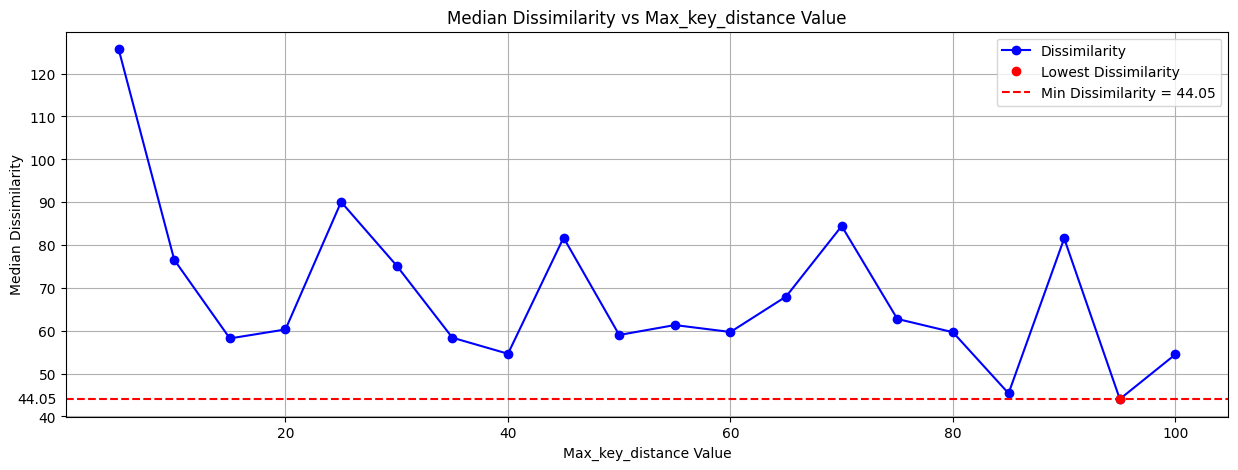

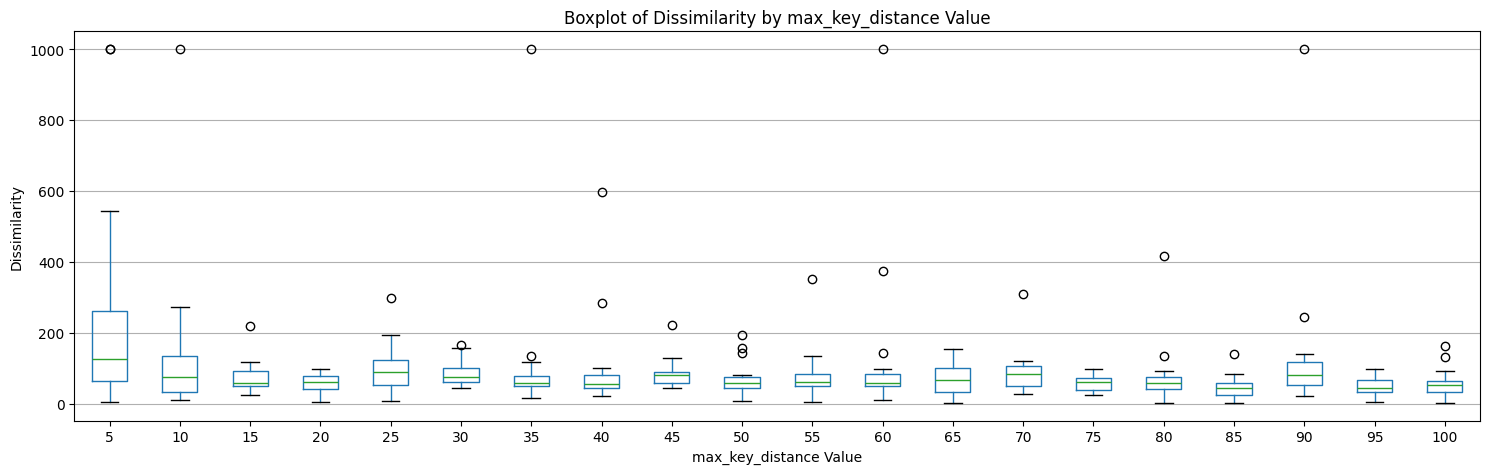

In [51]:
df = pd.read_csv('./results/df_model_test_max_key_distance_ranges.csv')

print(f"Df before dropping [] values: \n{df.shape}")

#drop rows for which "generated_midi_data" is []
df = df[df['generated_midi_data'].apply(lambda x: x != '[]')]
df['max_key_distance'] = df['max_key_distance'].round(1)  # Round to 1 decimal place

print(f"Df after dropping [] values: \n{df.shape}")

# Group by the column and calculate the median of 'dissimilarity'
median_dissimilarity = df.groupby("max_key_distance")["dissimilarity"].median()

# Find the threshold and value with the lowest dissimilarity
min_dissimilarity_value = median_dissimilarity.min()
min_threshold_value = median_dissimilarity.idxmin()

# Plotting the line plot
plt.figure(figsize=(15, 5))
plt.plot(median_dissimilarity.index, median_dissimilarity.values, marker='o', linestyle='-', color='b', label="Dissimilarity")

# Highlight the minimum point
plt.plot(min_threshold_value, min_dissimilarity_value, 'ro', label="Lowest Dissimilarity")

# Draw a red dotted line at the minimum point
plt.axhline(y=min_dissimilarity_value, color='r', linestyle='--', label=f'Min Dissimilarity = {min_dissimilarity_value:.2f}')

# Annotate the value of the lowest dissimilarity on the plot
plt.text(median_dissimilarity.index.min() - 5.6, min_dissimilarity_value, f'{min_dissimilarity_value:.2f}', 
         color='black', ha='right', va='center')
# Labeling
plt.xlabel(f'{"max_key_distance".capitalize()} Value')
plt.ylabel('Median Dissimilarity')
plt.title(f'Median Dissimilarity vs {"max_key_distance".capitalize()} Value')

# Display the grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Create the boxplot
ax = df.boxplot(column="dissimilarity", by="max_key_distance", grid=False, showfliers=True)
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Set to 1 decimal place

# Adjust the figure size after creating the plot
fig = plt.gcf()
fig.set_size_inches(15, 5)

# Adjust the plot labels and title
plt.xlabel('max_key_distance Value')
plt.ylabel('Dissimilarity')
plt.title('Boxplot of Dissimilarity by max_key_distance Value')
plt.suptitle('')  # Removes the automatic title from pandas boxplot
plt.grid(True, axis='y')

# Adjust layout to prevent clipping
plt.tight_layout()

plt.show()

## Test with best values median and mean analysis

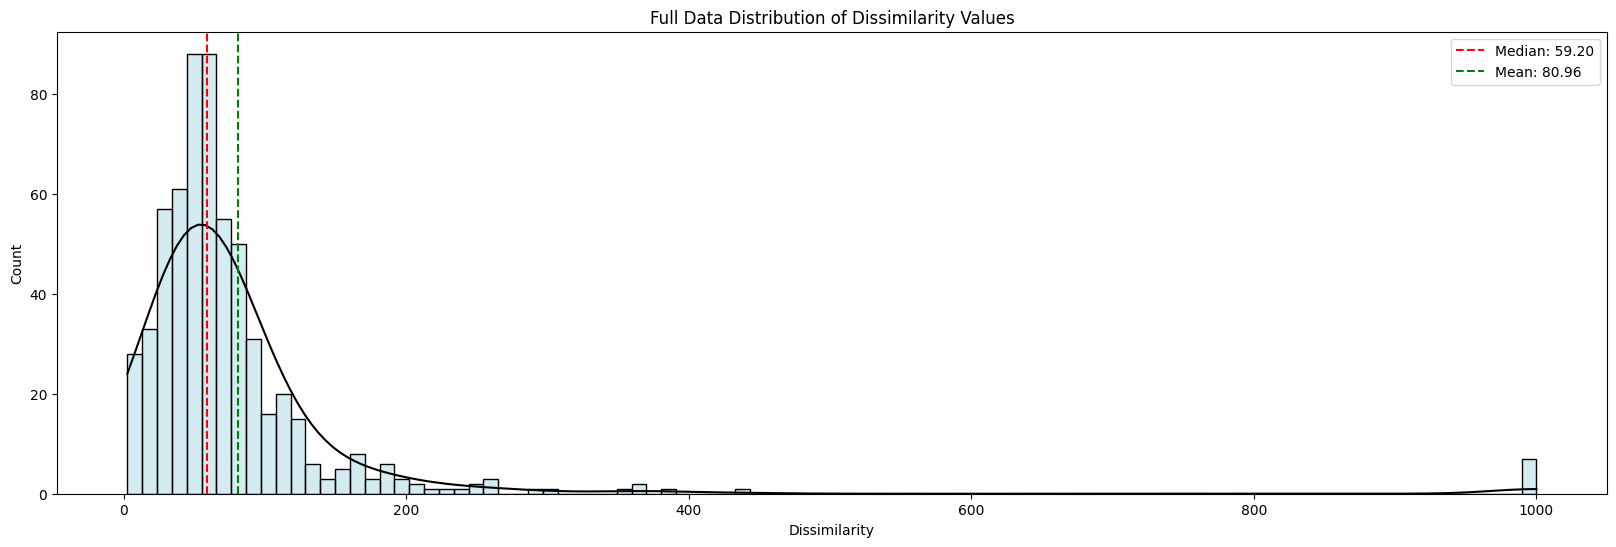

In [73]:
df = pd.read_csv('./results/df_model_test_with_best_values.csv')

median_value = df['dissimilarity'].median()
mean_value = df['dissimilarity'].mean()

# Create the figure
plt.figure(figsize=(20, 6))

# Plot the histogram (without KDE) and the KDE separately
ax = sns.histplot(df['dissimilarity'], kde=True, color='lightblue', edgecolor='black')  # Light blue bars, black edges
ax.lines[0].set_color('black')

# Add vertical lines for the median and mean
plt.axvline(median_value, color='red', linestyle='--', linewidth=1.5, label=f'Median: {median_value:.2f}')
plt.axvline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')

# Titles and labels
plt.title('Full Data Distribution of Dissimilarity Values')
plt.xlabel('Dissimilarity')

# Display the legend
plt.legend()

# Show the plot
plt.show()


Df before dropping [] values: 
(3600, 10)
Df after dropping [] values: 
(3600, 10)
Number of rows: 3600
30
Column: threshold
threshold
1.00    300
1.25    300
1.50    300
1.75    300
2.00    300
2.25    300
2.50    300
2.75    300
3.00    300
3.25    300
3.50    300
3.75    300
Name: count, dtype: int64
Column: fan_out
fan_out
5     360
10    360
15    360
20    360
25    360
30    360
35    360
40    360
45    360
50    360
Name: count, dtype: int64
Column: max_distance_atan
max_distance_atan
50     600
60     600
70     600
80     600
90     600
100    600
Name: count, dtype: int64
Column: onset_threshold
onset_threshold
0.5    3600
Name: count, dtype: int64
Column: frame_threshold
frame_threshold
0.3    3600
Name: count, dtype: int64
Column: max_key_distance
max_key_distance
20    720
40    720
50    720
30    720
10    720
Name: count, dtype: int64


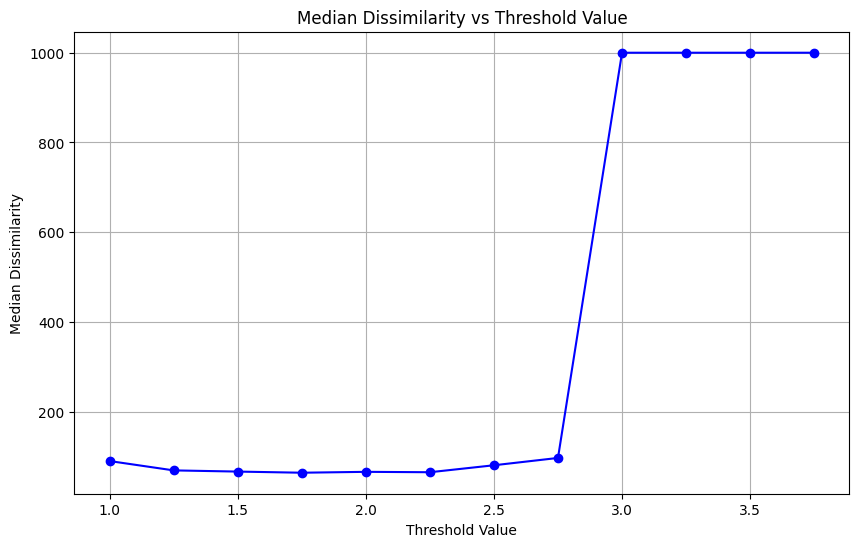

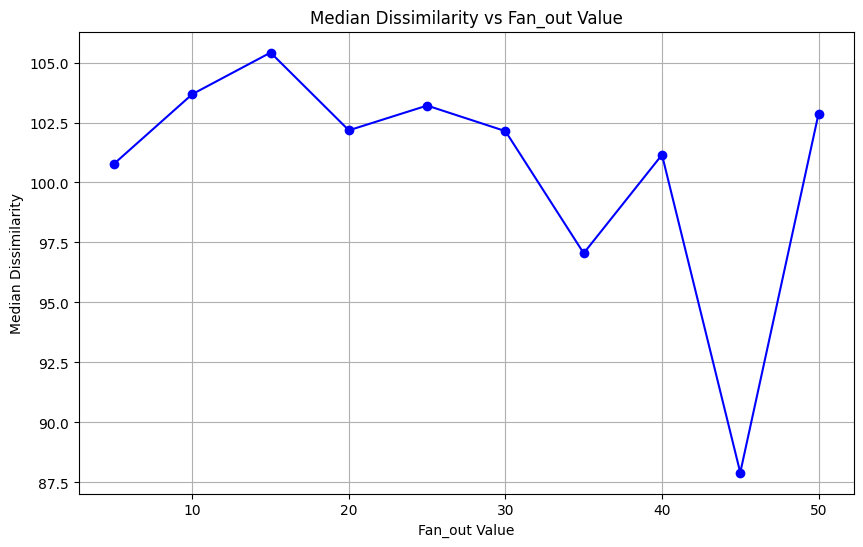

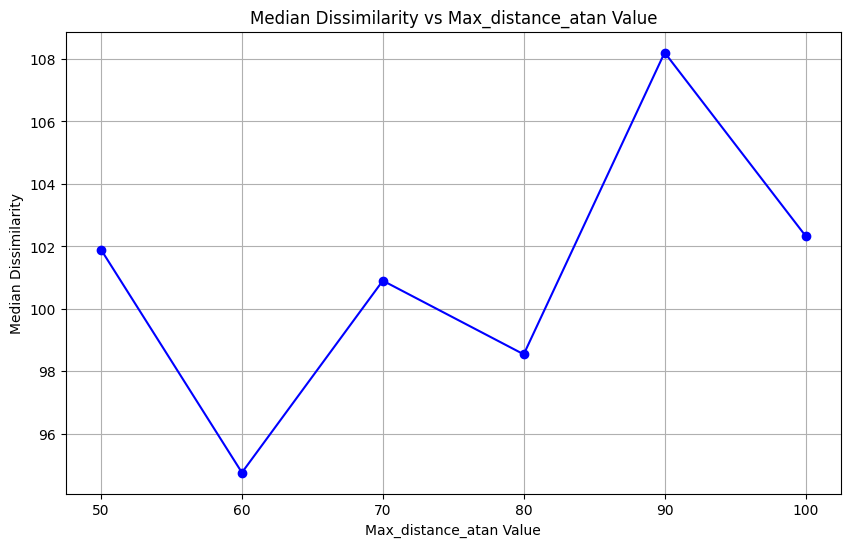

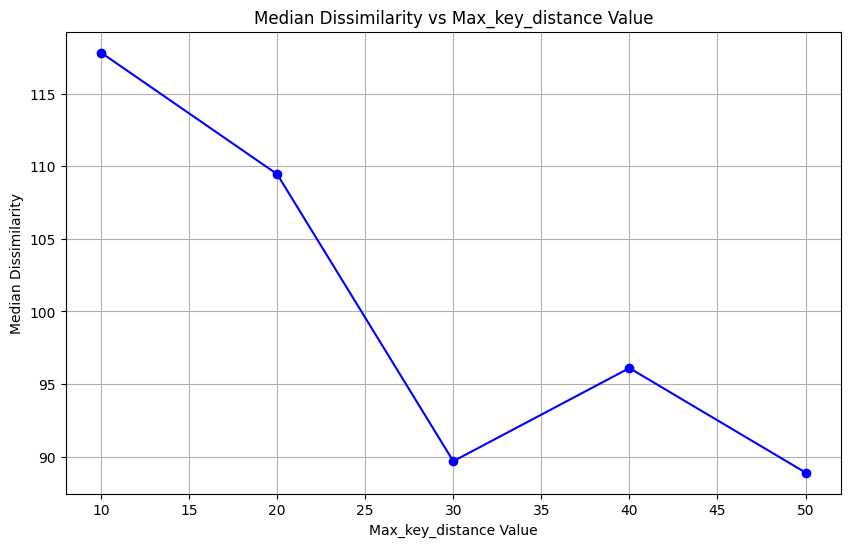

<Figure size 1000x600 with 0 Axes>

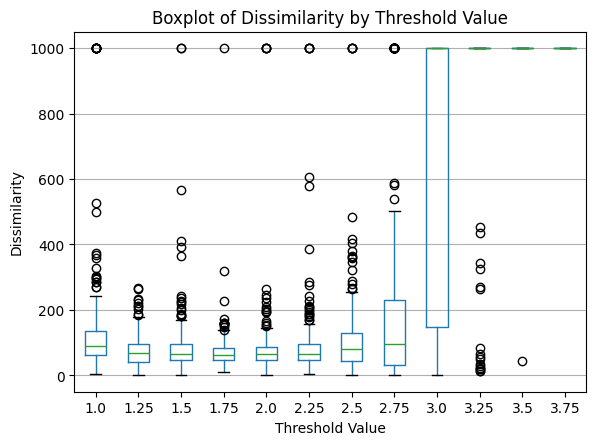

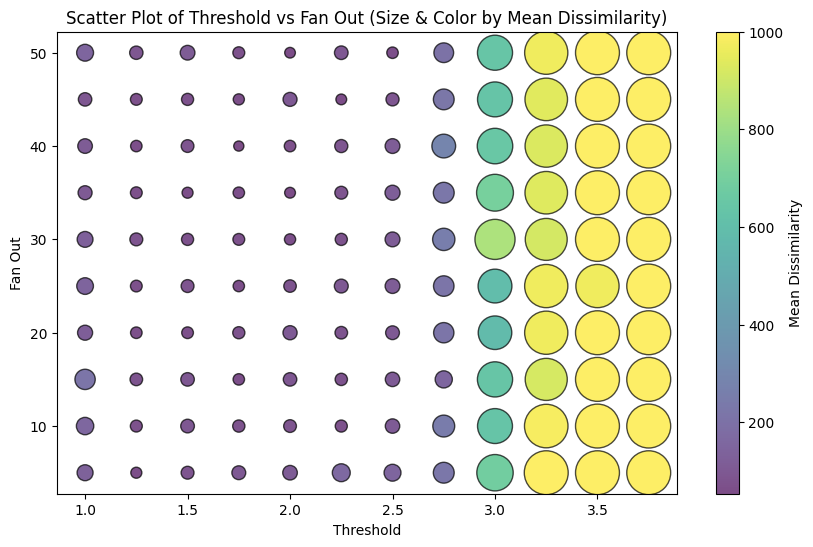

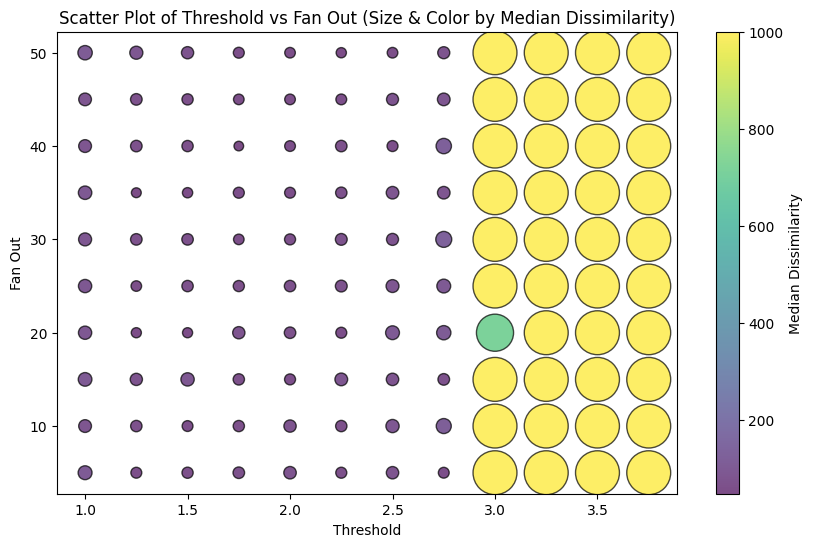

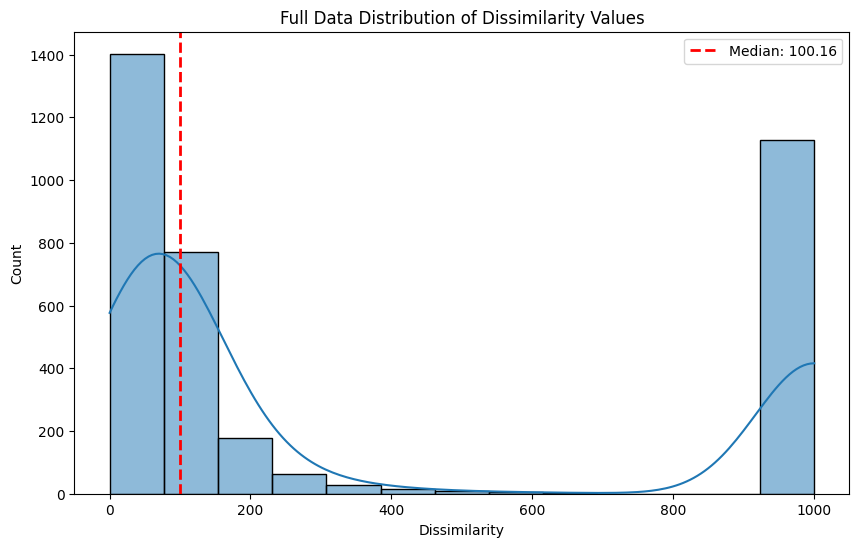

In [41]:
df = pd.read_csv('./results/df_model_test_3600_test.csv')

print(f"Df before dropping [] values: \n{df.shape}")

#drop rows for which "generated_midi_data" is []
df = df[df['generated_midi_data'].apply(lambda x: x != '[]')]

print(f"Df after dropping [] values: \n{df.shape}")

# Get the number of rows
num_rows = df.shape[0]
print("Number of rows:", num_rows)

result = ((df['threshold'] == 1) & (df['fan_out'] == 10)).sum()

print(result)

columns_to_analyze = ["threshold", "fan_out", "max_distance_atan", "onset_threshold", "frame_threshold", "max_key_distance"]

for column in columns_to_analyze:
    value_counts = df[column].value_counts()
    print(f"Column: {column}")
    print(value_counts)
    
columns_to_analyze = ["threshold", "fan_out", "max_distance_atan", "max_key_distance"]

# Iterate over the columns to create the line plot for each
for column in columns_to_analyze:
    # Group by the column and calculate the median of 'dissimilarity'
    median_dissimilarity = df.groupby(column)["dissimilarity"].median()
    
    # Plotting the line plot
    plt.figure(figsize=(10, 6))
    plt.plot(median_dissimilarity.index, median_dissimilarity.values, marker='o', linestyle='-', color='b')
    plt.xlabel(f'{column.capitalize()} Value')
    plt.ylabel('Median Dissimilarity')
    plt.title(f'Median Dissimilarity vs {column.capitalize()} Value')
    plt.grid(True)
    plt.show()

# Box plot
plt.figure(figsize=(10, 6))
df.boxplot(column="dissimilarity", by="threshold", grid=False, showfliers=True)

# Adjust the plot labels and title
plt.xlabel('Threshold Value')
plt.ylabel('Dissimilarity')
plt.title('Boxplot of Dissimilarity by Threshold Value')
plt.suptitle('')  # Removes the automatic title from pandas boxplot
plt.grid(True, axis='y')
plt.show()

# Group by 'threshold' and 'fan_out' to calculate the median dissimilarity
grouped_mean = df.groupby(['threshold', 'fan_out'])['dissimilarity'].mean().reset_index()

# Create a scatter plot where size and color represent the median dissimilarity
plt.figure(figsize=(10, 6))

# Scatter plot with variable circle size based on median dissimilarity
# 's' parameter controls the size of circles, scaled by median dissimilarity
scatter = plt.scatter(grouped_mean['threshold'], grouped_mean['fan_out'], 
                      c=grouped_mean['dissimilarity'], s=grouped_mean['dissimilarity'], 
                      cmap='viridis', edgecolor='k', alpha=0.7)

# Add a color bar to indicate dissimilarity scale
cbar = plt.colorbar(scatter)
cbar.set_label('Mean Dissimilarity')

# Plot settings without grid
plt.xlabel('Threshold')
plt.ylabel('Fan Out')
plt.title('Scatter Plot of Threshold vs Fan Out (Size & Color by Mean Dissimilarity)')
plt.grid(False)  # Disable the grid
plt.show()

grouped_median = df.groupby(['threshold', 'fan_out'])['dissimilarity'].median().reset_index()
# Create a scatter plot where size and color represent the median dissimilarity
plt.figure(figsize=(10, 6))

# Scatter plot with variable circle size based on median dissimilarity
# 's' parameter controls the size of circles, scaled by median dissimilarity
scatter = plt.scatter(grouped_median['threshold'], grouped_median['fan_out'], 
                      c=grouped_median['dissimilarity'], s=grouped_median['dissimilarity'], 
                      cmap='viridis', edgecolor='k', alpha=0.7)

# Add a color bar to indicate dissimilarity scale
cbar = plt.colorbar(scatter)
cbar.set_label('Median Dissimilarity')

# Plot settings without grid
plt.xlabel('Threshold')
plt.ylabel('Fan Out')
plt.title('Scatter Plot of Threshold vs Fan Out (Size & Color by Median Dissimilarity)')
plt.grid(False)  # Disable the grid
plt.show()

# Calculate the median dissimilarity value
median_value = df['dissimilarity'].median()

# Histogram of dissimilarity values
plt.figure(figsize=(10, 6))
sns.histplot(df['dissimilarity'], kde=True)
plt.axvline(median_value, color='red', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f}')
plt.title('Full Data Distribution of Dissimilarity Values')
plt.xlabel('Dissimilarity')
plt.legend()
plt.show()